# SMS Spam Detection with Llama 3.1 Fine-Tuning

Bu notebook’ta, SMS mesajlarını "spam" veya "ham" olarak sınıflandırmak amacıyla Llama 3.1 modelini fine-tune edeceğiz.  
Elimizdeki `sms_spam_train.csv` dosyasında sadece eğitim verisi bulunuyor. (Readme’de bu duruma dair bir açıklama yer almıyor.)  
İş akışımız şu adımlardan oluşacak:
1. Gerekli kütüphanelerin yüklenmesi ve veri setinin okunması  
2. Veri keşfi (EDA) ve ön işleme  
3. Veriyi fine-tuning için uygun formata dönüştürme  
4. Llama 3.1 modelinin ve tokenizer’ın yüklenmesi  
5. Modelin LoRA adaptörleri ile fine-tuning’e hazırlanması  
6. Fine-tuning işleminin gerçekleştirilmesi  
7. Eğitilen modelin test edilmesi ve kaydedilmesi


## Adım 1: Gerekli Kütüphanelerin Yüklenmesi ve Veri Setinin Okunması

Öncelikle veri setimizi yükmek ve temel kütüphaneleri import etmek gerekiyor.


In [7]:
# Import işlemleri
import pandas as pd
import numpy as np
import re
import os
from datasets import Dataset, load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Transformer ve fine-tuning kütüphaneleri
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, GenerationConfig
from peft import LoraConfig
from trl import SFTTrainer

# Zaman ölçümü için
from time import perf_counter
import os
from pathlib import Path
import pandas as pd


# Veri setinin okunması
base_dir = Path.cwd().parent  # Çalışma dizininin (notebooks) üst dizinine geçer.
dataset_path = base_dir / "datasets" / "sms_spam_train.csv"
df = pd.read_csv(dataset_path)

## Adım 2: Veri Keşfi (EDA)

- Veri setindeki örnek sayısına, etiket dağılımına bakacağız.
- İlk örnekleri inceleyerek veri yapısını gözlemleyeceğiz.


Etiket dağılımı:
Label
ham     6621
spam    3379
Name: count, dtype: int64


C:\Users\Hakan\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


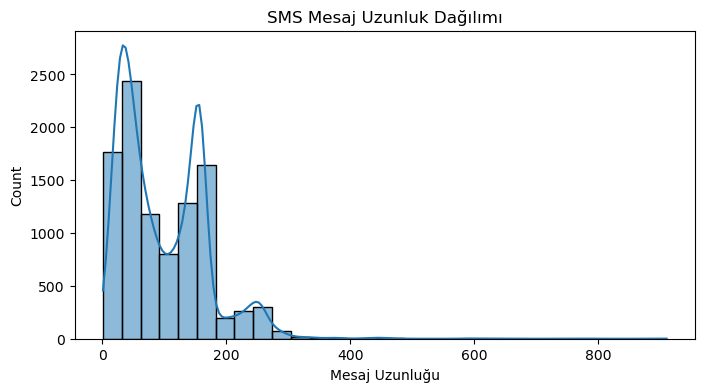

In [8]:
# Etiket dağılımı
print("Etiket dağılımı:")
print(df['Label'].value_counts())

# Mesaj uzunluklarına dair örnek analiz (opsiyonel)
df['msg_length'] = df['Message'].apply(len)
plt.figure(figsize=(8,4))
sns.histplot(df['msg_length'], bins=30, kde=True)
plt.xlabel("Mesaj Uzunluğu")
plt.title("SMS Mesaj Uzunluk Dağılımı")
plt.show()


## Adım 3: Veri Ön İşleme

- Metinleri küçük harfe çevirme ve gereksiz karakterleri temizleme gibi temel işlemleri uygulayacağız.


In [9]:
def clean_text(text):
    """
    Metni küçük harfe çevirir ve harf, rakam ile boşluk dışındaki karakterleri temizler.
    """
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9ğüşıöç\s]', '', text)
    return text

# Temizlenmiş metin sütunu oluşturma
df['Clean_Message'] = df['Message'].apply(clean_text)
print("Temizlenmiş örnek mesajlar:")
display(df[['Message', 'Clean_Message']].head())


Temizlenmiş örnek mesajlar:


,Message,Clean_Message
0,Whats upp ac enisteee: -) senin memlekette bul...,whats upp ac enisteee senin memlekette buldum
1,"Kampanya, VakifBank Worldcardla 31 Mayisa kada...",kampanya vakifbank worldcardla 31 mayisa kadar...
2,I wont. So wat's wit the guys,i wont so wats wit the guys
3,Bu arada son dakika evi düşürdük,bu arada son dakika evi düşürdük
4,No that just means you have a fat head,no that just means you have a fat head


## Adım 4: Dataset’i Fine-Tuning İçin Hazırlama

Bu adımda, her SMS örneğini modelin eğitim formatına uygun bir "konuşma" (conversation) formatına dönüştüreceğiz.  
Aşağıdaki formatı kullanacağız:

<|im_start|>system
You are an SMS classifier. Classify the following message as either "spam" or "ham".
<|im_end|>

<|im_start|>user
Message: {SMS mesajı}
<|im_end|>

<|im_start|>assistant
{etiket}
<|im_end|>


Bu yapı, modelin eğitimi sırasında hem giriş (SMS mesajı) hem de beklenen çıkış (etiket) bilgisini sağlamış olacak.


In [10]:
def format_example(message, label):
    prompt = f"<|im_start|>user\nSMS: {message}\nWhat is the label? (spam/ham)<|im_end|>\n<|im_start|>assistant\n"
    response = label + "<|im_end|>\n"
    return {"prompt": prompt, "response": response}

# Örnek olarak bir örnek hazırlayalım
example = format_example("This is a test message", "ham")
print("Prompt:\n", example["prompt"])
print("Response:\n", example["response"])


Prompt:
 <|im_start|>user
SMS: This is a test message
What is the label? (spam/ham)<|im_end|>
<|im_start|>assistant

Response:
 ham<|im_end|>



## 5. Eğitim ve Validasyon Verisinin Oluşturulması

Elimizde sadece eğitim verisi var. Bu nedenle verinin %80'ini eğitim, %20'sini validasyon olarak ayıracağız.


In [11]:
from sklearn.model_selection import train_test_split

# Eğitim ve validation set'lerini ayıralım
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Label'], random_state=42)

print("Eğitim seti boyutu:", train_df.shape)
print("Validation seti boyutu:", val_df.shape)


Eğitim seti boyutu: (8000, 4)
Validation seti boyutu: (2000, 4)


## 7. Eğitim Verisinin Hazırlanması

Verilen eğitim (train_df) ve validasyon (val_df) verilerini prompt-response formatına çevirip Hugging Face `Dataset` formatına dönüştürelim.


In [12]:

# Eğitim verisi için prompt-response örneklerini oluşturalım
train_data = [format_example(row['Clean_Message'], row['Label']) for _, row in train_df.iterrows()]
val_data = [format_example(row['Clean_Message'], row['Label']) for _, row in val_df.iterrows()]

# Pandas DataFrame'den HuggingFace Dataset'e çevirelim
train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))
val_dataset = Dataset.from_pandas(pd.DataFrame(val_data))

print("Eğitim veri örnekleri:")
display(train_dataset[0])


Eğitim veri örnekleri:


{'prompt': '<|im_start|>user\nSMS: i dont run away frm u i walk slowly amp it kills me that u dont care enough to stop me\nWhat is the label? (spam/ham)<|im_end|>\n<|im_start|>assistant\n',
 'response': 'ham<|im_end|>\n'}

## 8. Llama 3.1 Modeli ve Tokenizer'ın Yüklenmesi

Aşağıdaki fonksiyon ile Hugging Face üzerinden Llama 3.1 modelini ve tokenizer'ı yüklüyoruz.  
**Not:** Modelin boyutuna göre Google Colab gibi ortamlarda hafıza (RAM) kısıtlamaları olabilir; bu durumda daha küçük bir model seçebilirsiniz.


In [13]:
model_id = "NousResearch/Hermes-3-Llama-3.1-8B"  # Veya kullandığınız uygun model id'sini belirtin

def get_model_and_tokenizer(model_id):
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    tokenizer.pad_token = tokenizer.eos_token  # Padding için eos_token kullanıyoruz
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True, 
        bnb_4bit_quant_type="nf4", 
        bnb_4bit_compute_dtype="float16", 
        bnb_4bit_use_double_quant=True
    )
    model = AutoModelForCausalLM.from_pretrained(
        model_id, 
        quantization_config=bnb_config, 
        device_map="auto"
    )
    model.config.use_cache = False
    model.config.pretraining_tp = 1
    return model, tokenizer

model, tokenizer = get_model_and_tokenizer(model_id)
print("Model ve tokenizer yüklendi.")


RuntimeError: Failed to import transformers.integrations.bitsandbytes because of the following error (look up to see its traceback):
DLL load failed while importing libtriton: Devingen bağlantı kitaplığını (DLL) başlatma işlemi başarısız.